# Sphere versus Torus

In this notebook, we attempt to use persistence landscapes to determine if TDA can tell the difference between a sphere and a torus. We sample 1000 points from each shape, compute the Vietoris-Rips persistent homology using Ripser, and then compute the respective landscapes. 

To determine if we can see a difference, we will repeat this process 100 times and then compute the mean landscape across these 100 runs.

...Finish intro...

#### Imports 

In [9]:
import numpy as np
from operator import itemgetter

from ripser import ripser
from tadasets import sphere, torus
from PersistenceLandscapeGrid import PersistenceLandscapeGrid
from visualization import plot_landscape

In [2]:
sphere_pts = sphere(n=1000)
torus_pts = torus(n=1000)

In [3]:
sphere_dgms = ripser(sphere_pts)['dgms']
torus_dgms = ripser(torus_pts)['dgms']

At this point, `PersistenceLandscapeGrid` requires the user to specify the parameters of a grid explicitly. Since we want to compare the diagrams from the sphere and torus, we compute the appropriate start and stop point.

In [4]:
hom_deg = 1
sph_b = min(sphere_dgms[hom_deg],key=itemgetter(0))[0]
sph_d = max(sphere_dgms[hom_deg],key=itemgetter(1))[1]
tor_b = min(torus_dgms[hom_deg],key=itemgetter(0))[0]
tor_d = max(torus_dgms[hom_deg],key=itemgetter(1))[1]

start = min(sph_b,tor_b)
stop = max(sph_d,tor_d)

(These are manually on the same grid, maybe we should try the snap_PL function instead.)

In [5]:
sph_pl = PersistenceLandscapeGrid(start=start,
                                 stop=stop,
                                 num_dims=500,
                                 dgms=sphere_dgms,
                                 hom_deg=1)
tor_pl = PersistenceLandscapeGrid(start=start,
                                 stop=stop,
                                 num_dims=500,
                                 dgms=torus_dgms,
                                 hom_deg=1)

In [6]:
sph_pl.compute_landscape()
tor_pl.compute_landscape()

In [7]:
diff_pl = sph_pl - tor_pl

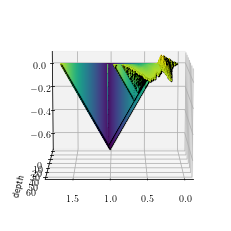

In [10]:
#%matplotlib inline
#plot_landscape(diff_pl)

(Put picture of diff here maybe, once the code is done.)

In [11]:
significant = diff_pl.sup_norm()

print(f'The threshold for significance is {significant}')

The threshold for significance is 0.7275626050282218


## 100 Runs

This is a single run. Now lets do it 100 times. This might be very slow. One way to speed it up is multiprocessing but we skip that for now.

Let's compute the start and stop parameters of our grid on the fly to save time.

In [17]:
sph_pl_list = []
tor_pl_list = []
#sph_b = 100.
#sph_d = -100.
#tor_b = 100.
#tor_d = -100.

for i in range(100):
    sph_pts = sphere(n=1000)
    sph_dgm = ripser(sph_pts)['dgms']
    sph_pl_list.append(PersistenceLandscapeGrid(dgms=sph_dgm,hom_deg=1,compute=True))
    
    tor_pts = torus(n=1000)
    tor_dgm = ripser(tor_pts)['dgms']
    tor_pl_list.append(PersistenceLandscapeGrid(dgms=tor_dgm,hom_deg=1,compute=True))

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [15]:
avg_sph_pl = sph_pl_list[0]
avg_tor_pl = tor_pl_list[0]

for i in range(1,100):
    avg_sph_pl += sph_pl_list[i]
    avg_tor_pl += tor_pl_list[i]

avg_sph_pl = avg_sph_pl/100.
avg_tor_pl = avg_tor_pl/100.

In [16]:
avg_sph_pl.sup_norm()

ValueError: zero-size array to reduction operation maximum which has no identity